### EDA SIIM-COVID19-DETECTION

Exploratory data analysis for SIIM-COVID19-DETECTION DATASET. URL: https://www.kaggle.com/competitions/siim-covid19-detection/

## 0. Libraries and global variables:

In [1]:
!conda config --remove channels <file:///tmp/conda>
!conda install gdcm -c conda-forge -y

/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `conda config --remove channels <file:///tmp/conda>'
Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.3
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.11.17 |       hbcca054_0         151 KB  conda-forge
    certifi-2023.11.17         |     pyhd8ed1ab_0         155 KB  conda-forge
    gdcm-2.8.9                 |  py310h1bfc968_9         2.7 MB  conda-forge
    json-c-0.17           

In [2]:
import os
import glob
import math
import re
import warnings
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pydicom
#import gdcm # Needed for decoding images of De-identification methods != DICOM locally.

from pydicom.pixel_data_handlers.util import apply_voi_lut
from random import randint
from tqdm.auto import tqdm

In [3]:
# GLOBAL variables
base_path = "../input/siim-covid19-detection/"
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")

In [4]:
# Filter out the specific warning
warnings.filterwarnings("ignore", message="Invalid value for VR UI")

## 1. Data description:

### 1.1 Labels data:

In [5]:
train_roi_labels = pd.read_csv(os.path.join(base_path,"train_image_level.csv"))
train_roi_labels.head()

id                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   
2  0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3  001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4  001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   

                                               label StudyInstanceUID  
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75  
1                                     none 1 0 0 1 1     ff0879eb20ed  
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7  
3    opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2  
4  opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e

In [6]:
# Number of instances
len(train_roi_labels)

6334

**boxes** - bounding boxes in easily-readable dictionary format

**label** - the correct prediction label for the provided bounding boxes

In [7]:
train_study_labels = pd.read_csv(os.path.join(base_path,"train_study_level.csv"))
train_study_labels.loc[:, "StudyInstanceUID"] = train_study_labels.id.str.split("_", expand=True).loc[:, 0]
del train_study_labels['id']
train_study_labels.head()

Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
0                       0                   1                         0   
1                       0                   0                         0   
2                       1                   0                         0   
3                       1                   0                         0   
4                       0                   0                         0   

   Atypical Appearance StudyInstanceUID  
0                    0     00086460a852  
1                    1     000c9c05fd14  
2                    0     00292f8c37bd  
3                    0     005057b3f880  
4                    1     0051d9b12e72

All images are stored in paths with the form study/series/image. The study ID here relates directly to the study-level predictions, and the image ID is the ID used for image-level predictions.

**Negative for Pneumonia** 	1 : if the study is negative for pneumonia, 0: otherwise

**Typical Appearance** 	1: if the study has this appearance, 0: otherwise

**Indeterminate Appearance** 	1: if the study has this appearance, 0: otherwise

**Atypical Appearance** 	1: if the study has this appearance, 0: otherwise

In [8]:
# Number of instances
len(train_study_labels)

6054

Probably some studies have more than one image. 

#### 1.1.1 Joining data labels:

In [9]:
train_labels = train_roi_labels.merge(train_study_labels, on='StudyInstanceUID')
train_labels.head()

id                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   
2  0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3  001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4  001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   

                                               label StudyInstanceUID  \
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                     none 1 0 0 1 1     ff0879eb20ed   
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   
3    opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
4  opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e   

   Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
0                       0                   1                         0   
1                       1                   0                         0   
2                       0                   1                         0   
3                       0                   0                         0   
4                       0                   1                         0   

   Atypical Appearance  
0                    0  
1                    0  
2                    0  
3                    1  
4                    0

#### 1.1.2 Adding image paths:

In [10]:
def create_paths(row):
    """
    Function to create image paths from df info.
    """

    return glob.glob(os.path.join(train_path,
                                  str(row.StudyInstanceUID),
                                   "*",
                                   str(row.id.split("_")[0]) + ".dcm"))[0]

In [11]:
train_labels['image_path'] = train_labels.apply(create_paths, axis=1)
train_labels.head()

id                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   
2  0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3  001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4  001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   

                                               label StudyInstanceUID  \
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                     none 1 0 0 1 1     ff0879eb20ed   
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   
3    opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
4  opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e   

   Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
0                       0                   1                         0   
1                       1                   0                         0   
2                       0                   1                         0   
3                       0                   0                         0   
4                       0                   1                         0   

   Atypical Appearance                                         image_path  
0                    0  ../input/siim-covid19-detection/train/5776db0c...  
1                    0  ../input/siim-covid19-detection/train/ff0879eb...  
2                    0  ../input/siim-covid19-detection/train/9d514ce4...  
3                    1  ../input/siim-covid19-detection/train/28dddc85...  
4                    0  ../input/siim-covid19-detection/train/dfd9fdd8...

In [60]:
# Adding integer label.
def label_row(row):
    if row['Typical Appearance'] == 1:
        return 0, 'typical'
    elif row['Indeterminate Appearance'] == 1:
        return 1, 'indeterminate'
    elif row['Atypical Appearance'] == 1:
        return 2, 'atypical'
    else:
        return 3, 'negative'

train_labels['int_label'], train_labels['y_label'] = zip(*train_labels.apply(label_row,
                                                                             axis=1))

In [61]:
train_labels.head(2)

id                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   

                                               label StudyInstanceUID  \
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                     none 1 0 0 1 1     ff0879eb20ed   

   Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
0                       0                   1                         0   
1                       1                   0                         0   

   Atypical Appearance                                         image_path  \
0                    0  ../input/siim-covid19-detection/train/5776db0c...   
1                    0  ../input/siim-covid19-detection/train/ff0879eb...   

   int_label   y_label  
0          0   typical  
1          3  negative

In [62]:
train_labels.to_csv(os.path.join("train.csv"), index=False)

#### 1.1.3 Missing values:

In [63]:
# Check for nulls.
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6334 entries, 0 to 6333
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        6334 non-null   object
 1   boxes                     4294 non-null   object
 2   label                     6334 non-null   object
 3   StudyInstanceUID          6334 non-null   object
 4   Negative for Pneumonia    6334 non-null   int64 
 5   Typical Appearance        6334 non-null   int64 
 6   Indeterminate Appearance  6334 non-null   int64 
 7   Atypical Appearance       6334 non-null   int64 
 8   image_path                6334 non-null   object
 9   int_label                 6334 non-null   int64 
 10  y_label                   6334 non-null   object
dtypes: int64(5), object(6)
memory usage: 544.5+ KB


Variable **boxes** with an easily-readable dictionary format sometimes is empty. **label** info should be used instad. 

In [64]:
# Check for empty strings in each column.
empty_string_counts = train_labels.apply(lambda col: col[col == ''].count())
print(empty_string_counts)

id                          0
boxes                       0
label                       0
StudyInstanceUID            0
Negative for Pneumonia      0
Typical Appearance          0
Indeterminate Appearance    0
Atypical Appearance         0
image_path                  0
int_label                   0
y_label                     0
dtype: int64


#### 1.1.4 Generating a dict to describe all the boxes in each image:

In [65]:
def process_row(row):
    return train_labels.loc[int(row.name[0]), "id"]

### Extraer los valores de 'label' usando una expresión regular
train_boxes = (train_labels['label']
                    .str.extractall(r'(opacity 1|none 1) (\d+.\d+|\d+) (\d+.\d+|\d+) (\d+.\d+|\d+) (\d+.\d+|\d+)'))

# Renombrar las columnas extraídas
train_boxes.columns = ['box_label', 'xmin', 'ymin', 'xmax', 'ymax']

train_boxes[['xmin', 'ymin', 'xmax', 'ymax']] = train_boxes[['xmin', 'ymin', 'xmax', 'ymax']].astype(float)

train_boxes["id"] = train_boxes.apply(process_row, axis=1)

train_boxes = train_boxes.reset_index()

train_boxes = pd.merge(train_boxes, train_labels, on='id')

del train_boxes["level_0"], train_boxes["match"], train_boxes["boxes"], train_boxes["label"]

train_boxes.head(5)

box_label        xmin       ymin        xmax        ymax  \
0  opacity 1   789.28836  582.43035  1815.94498  2499.73327   
1  opacity 1  2245.91208  591.20528  3340.57370  2352.75472   
2     none 1     0.00000    0.00000     1.00000     1.00000   
3  opacity 1   677.42216  197.97662  1545.21983  1197.75876   
4  opacity 1  1792.69064  402.55250  2409.71798  1606.91050   

                   id StudyInstanceUID  Negative for Pneumonia  \
0  000a312787f2_image     5776db0cec75                       0   
1  000a312787f2_image     5776db0cec75                       0   
2  000c3a3f293f_image     ff0879eb20ed                       1   
3  0012ff7358bc_image     9d514ce429a7                       0   
4  0012ff7358bc_image     9d514ce429a7                       0   

   Typical Appearance  Indeterminate Appearance  Atypical Appearance  \
0                   1                         0                    0   
1                   1                         0                    0   
2                   0                         0                    0   
3                   1                         0                    0   
4                   1                         0                    0   

                                          image_path  int_label   y_label  
0  ../input/siim-covid19-detection/train/5776db0c...          0   typical  
1  ../input/siim-covid19-detection/train/5776db0c...          0   typical  
2  ../input/siim-covid19-detection/train/ff0879eb...          3  negative  
3  ../input/siim-covid19-detection/train/9d514ce4...          0   typical  
4  ../input/siim-covid19-detection/train/9d514ce4...          0   typical

#### 1.1.5 Creating a csv for test data:

In [66]:
def get_filenames_df(folder_path):
    """
    Function reads all image files in a given directory and creates
    a dataframe with the image id and its full path.
    """
    filenames_dict = {'id': [], 'image_path': []}

    for dirname, _, filenames in tqdm(os.walk(folder_path)):
        for file in filenames:
            full_path = os.path.join(dirname, file)
            filenames_dict['image_path'].append(full_path)
            
            filename_without_extension = file.split('.')[0]
            filenames_dict['id'].append(f'{filename_without_extension}_image')

    return pd.DataFrame(filenames_dict)

In [17]:
test_csv = get_filenames_df(test_path)
test_csv.to_csv(os.path.join("test.csv"), index=False)

0it [00:00, ?it/s]

### 1.2 Image level data:

#### 1.2.1 DICOM files exploration:

In [18]:
voi_lut=True
fix_monochrome=True


def extract_dicom_data(filename, func='get_image'):
    """Credit: https://github.com/pydicom/pydicom/issues/319
               https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
               
    Function corrects dicom pixel data to prevent x-rays from looking inverted and extracts metadata.
    args:
        filename: DICOM file path (str)
        func: 'get_image' to extract only image data from file. (str)
              'get_metadata' to extract only metadata from file. (str)
              'get_all' to extract metadata, and image data (str)
    returns:
         'get_image' to extract only image data from file. (pixel array)
         'get_metadata' to extract only metadata from file. (dict)
         'get_all' to extract metadata, and image data ((dict, pixel array))
    """
    def _sanitise_unicode(s):
        return s.replace(u"\u0000", "").strip()

    def _convert_value(v):
        t = type(v)
        if t in (list, int, float):
            cv = v
        elif t == str:
            cv = _sanitise_unicode(v)
        elif t == bytes:
            s = v.decode('ascii', 'replace')
            cv = _sanitise_unicode(s)
        elif t == pydicom.valuerep.DSfloat:
            cv = float(v)
        elif t == pydicom.valuerep.IS:
            cv = int(v)
        else:
            cv = repr(v)
        return cv
    
    assert func in ['get_image', 'get_metadata', 'get_all'], f"Variable has an unexpected value: {func}"

    dicom_header = pydicom.dcmread(filename) 
    
    if func != 'get_metadata':
        #====== DICOM IMAGE DATA ======
        # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
        if voi_lut:
            data = apply_voi_lut(dicom_header.pixel_array, dicom_header)
        else:
            data = dicom_header.pixel_array
        # depending on this value, X-ray may look inverted - fix that:
        if fix_monochrome and dicom_header.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data
        data = data - np.min(data)
        data = data / np.max(data)
        modified_image_data = (data * 255).astype(np.uint8)
        
        if func == 'get_image':
            return modified_image_data
    
    elif func != 'get_image':
        #====== DICOM FILE DATA ======
        dicom_dict = {}
        repr(dicom_header)
        for dicom_value in dicom_header.values():
            if dicom_value.tag == (0x7fe0, 0x0010):
                #discard pixel data
                continue
            if type(dicom_value.value) == pydicom.dataset.Dataset:
                dicom_dict[dicom_value.name] = dicom_dataset_to_dict(dicom_value.value)
            else:
                v = _convert_value(dicom_value.value)
                dicom_dict[dicom_value.name] = v

        del dicom_dict['Pixel Representation']

        if func == 'get_metadata':
            return dicom_dict
    else:
        return dicom_dict, modified_image_data

In [19]:
def plot_DICOM(images_paths, boxes=None, title=None,
               images_titles=None, resize_shape=(2000,2000)):
    """
    Function to plot a variable number of DICOM images.
    args:
        images_paths: list of image paths. (list of strings)
        boxes: List of bounding boxes for each image (list of lists of floats)
        title: String for figure title. (str)
        images_titles: List of strings for image titles. (list of strings)
    """

    num_images = len(images_paths)
    
    cols = int(math.ceil(math.sqrt(num_images)))
    rows = int(math.ceil(num_images / cols))
    
    fig = plt.figure(figsize=(9, 8))
    gs = gridspec.GridSpec(rows, cols,
                           width_ratios=[1] * cols,
                           height_ratios=[1] * rows)
    
    for i, image_path in enumerate(images_paths):
    
        image_data = extract_dicom_data(image_path)
        image_data = np.stack([image_data, image_data, image_data],
                              axis=-1) # To RGB.
        
        # Plot bounding boxes if provided.
        if boxes is not None:
            if not boxes[i]:
                print(f'There is no ROI present in image {i + 1}.')
            elif len(boxes[i])%4!=0:
                print(f'Boxes provided have wrong format for image {i + 1}.')
            else:
                for n_box in range(0, int(len(boxes[i])/4)):
                    color = [randint(0, 255), randint(0, 255), randint(0, 255)]

                    x = int(boxes[i][0 + n_box*4])
                    y = int(boxes[i][1 + n_box*4])
                    w = int(boxes[i][2 + n_box*4])
                    h = int(boxes[i][3 + n_box*4])
                    
                    image_data = cv2.rectangle(image_data, (x, y), (w, h), color=color, thickness=20)

        image_data = cv2.resize(image_data, resize_shape)
        ax = plt.subplot(gs[i])
        ax.grid(False)
        ax.imshow(image_data)

        if images_titles is not None:
            ax.set_title(images_titles[i])
        else:
            ax.set_title(f'Image {i + 1}')

    if title is not None:
        plt.suptitle(title)

    plt.tight_layout()
    plt.show()

Examples of DICOM files:

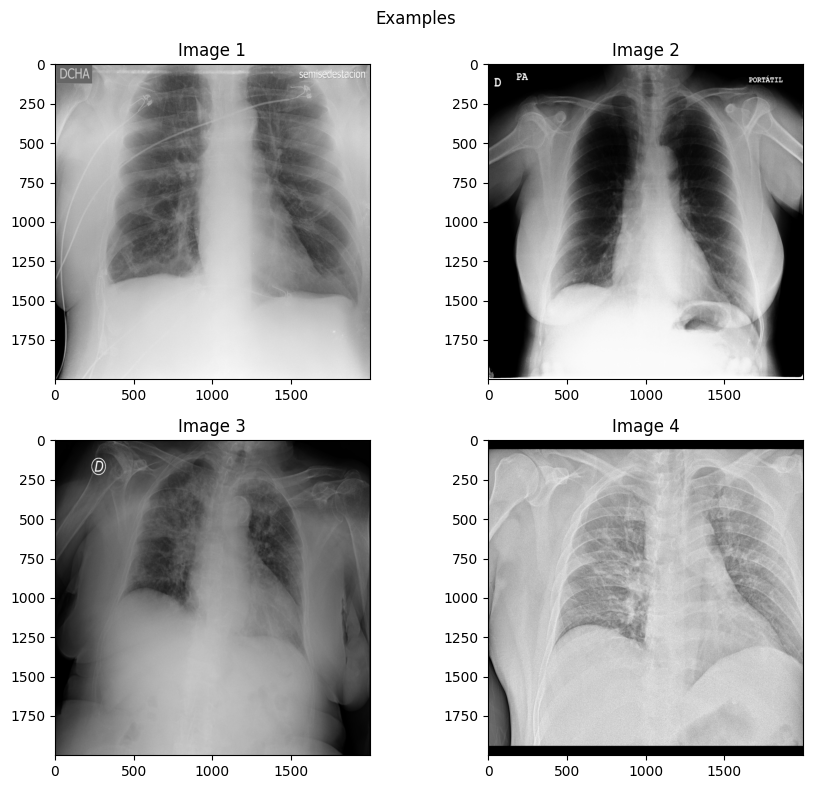

In [20]:
imgs_test_path = [train_labels.iloc[1]['image_path'],
                  train_labels.iloc[3]['image_path'],
                  train_labels.iloc[2]['image_path'],
                  train_labels.iloc[155]['image_path']]

plot_DICOM(imgs_test_path, title="Examples")

In [21]:
# Image shapes:
dcm_1 = pydicom.dcmread(imgs_test_path[0])
print(dcm_1.pixel_array.shape)

dcm_2 = pydicom.dcmread(imgs_test_path[2])
print(dcm_2.pixel_array.shape)

(2320, 2832)
(2544, 3056)


Image data is given in DICOM format and have variable shapes but all of them are quite large. Resize will be needed for future classification tasks. 

DICOM files contain also metadata:

In [22]:
print(f'METADATA for DICOM file: {imgs_test_path[0]} \n')
extract_dicom_data(imgs_test_path[0], func="get_metadata")

METADATA for DICOM file: ../input/siim-covid19-detection/train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f.dcm 



{'Specific Character Set': 'ISO_IR 100',
 'Image Type': "['ORIGINAL', 'PRIMARY']",
 'SOP Class UID': "'03a65300fa41'",
 'SOP Instance UID': "'000c3a3f293f'",
 'Study Date': 'd09eda152722',
 'Study Time': '543adb46f494',
 'Accession Number': '1c2708371bc6',
 'Modality': 'CR',
 "Patient's Name": "'ef8c31f8dfdd'",
 'Patient ID': 'f09ff9b7dab3',
 "Patient's Sex": 'M',
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'Body Part Examined': 'CHEST',
 'Imager Pixel Spacing': '[0.15, 0.15]',
 'Study Instance UID': "'ff0879eb20ed'",
 'Series Instance UID': "'d8a644cc4f93'",
 'Study ID': '55625fb42f3f',
 'Series Number': 1,
 'Instance Number': 1,
 'Samples per Pixel': 1,
 'Photometric Interpretation': 'MONOCHROME2',
 'Rows': 2320,
 'Columns': 2832,
 'Bits Allocated': 8,
 'Bits Stored': 8,
 'High Bit': 7}

De-identification methods refer to techniques or processes used to remove or anonymize personally identifiable information (PII) from data, especially in the context of sensitive information like medical records or other private datasets. The goal is to protect individuals' privacy by ensuring that the data cannot be directly linked to specific individuals.

In the context of medical imaging and DICOM (Digital Imaging and Communications in Medicine) files, de-identification methods are applied to remove or anonymize patient-specific information, such as names, dates of birth, and other identifiers, while retaining the necessary clinical information for research or analysis purposes. This is crucial for complying with privacy regulations and standards in the healthcare and research domains.

These methods help balance the need for sharing and using data for research or analysis while protecting individuals' privacy and complying with legal and ethical standards.


Evidently, parts of this data have undergone censorship. The upcoming data analysis will specifically focus on exploring the segments that have not been subject to censorship.

#### 1.2.2 DICOM metadata to CSV:

In [23]:
df_metadata = train_labels.apply(lambda row: pd.Series({**{'id': row['id']},
                                                        **extract_dicom_data(row['image_path'],
                                                                             func="get_metadata")}),
                                 axis=1)

In [69]:
df_metadata.head(2)

Accession Number  Bits Allocated  Bits Stored Body Part Examined  Columns  \
0     f6cd7f2019f5              16           12              CHEST     4256   
1     1c2708371bc6               8            8              CHEST     2832   

                            De-identification Method  \
0  CTP Default:  based on DICOM PS3.15 AnnexE. De...   
1  CTP Default:  based on DICOM PS3.15 AnnexE. De...   

  De-identification Method Code Sequence  High Bit               Image Type  \
0                   <Sequence, length 6>        11  ['ORIGINAL', 'PRIMARY']   
1                   <Sequence, length 6>         7  ['ORIGINAL', 'PRIMARY']   

  Imager Pixel Spacing  ... SOP Instance UID Samples per Pixel  \
0           [0.1, 0.1]  ...   '000a312787f2'                 1   
1         [0.15, 0.15]  ...   '000c3a3f293f'                 1   

  Series Instance UID Series Number Specific Character Set    Study Date  \
0      '81456c9c5423'             1             ISO_IR 100  526316e376d4   
1      'd8a644cc4f93'             1             ISO_IR 100  d09eda152722   

       Study ID  Study Instance UID    Study Time                  id  
0  55625fb42f3f      '5776db0cec75'  8ccfb6acf07f  000a312787f2_image  
1  55625fb42f3f      'ff0879eb20ed'  543adb46f494  000c3a3f293f_image  

[2 rows x 29 columns]

In [25]:
# Save the DataFrame to a CSV file.
df_metadata.to_csv(os.path.join("train_metadata.csv"), index=False)

#### 1.2.3 Add DICOM shape to train CSV and store it.

In [67]:
# Add image shape info to train DF and save it to CSV.
# Merge only the 'name' column from df1 and 'age' column from df2 based on the 'id' column
train_boxes = pd.merge(train_boxes, df_metadata[['id', 'Rows', 'Columns']], on='id')
train_boxes.rename(columns={'Rows':'rows', 'Columns': 'columns'}, inplace=True)
train_boxes.to_csv(os.path.join("train_boxes.csv"), index=False)

In [68]:
train_boxes.head(5)

box_label        xmin       ymin        xmax        ymax  \
0  opacity 1   789.28836  582.43035  1815.94498  2499.73327   
1  opacity 1  2245.91208  591.20528  3340.57370  2352.75472   
2     none 1     0.00000    0.00000     1.00000     1.00000   
3  opacity 1   677.42216  197.97662  1545.21983  1197.75876   
4  opacity 1  1792.69064  402.55250  2409.71798  1606.91050   

                   id StudyInstanceUID  Negative for Pneumonia  \
0  000a312787f2_image     5776db0cec75                       0   
1  000a312787f2_image     5776db0cec75                       0   
2  000c3a3f293f_image     ff0879eb20ed                       1   
3  0012ff7358bc_image     9d514ce429a7                       0   
4  0012ff7358bc_image     9d514ce429a7                       0   

   Typical Appearance  Indeterminate Appearance  Atypical Appearance  \
0                   1                         0                    0   
1                   1                         0                    0   
2                   0                         0                    0   
3                   1                         0                    0   
4                   1                         0                    0   

                                          image_path  int_label   y_label  \
0  ../input/siim-covid19-detection/train/5776db0c...          0   typical   
1  ../input/siim-covid19-detection/train/5776db0c...          0   typical   
2  ../input/siim-covid19-detection/train/ff0879eb...          3  negative   
3  ../input/siim-covid19-detection/train/9d514ce4...          0   typical   
4  ../input/siim-covid19-detection/train/9d514ce4...          0   typical   

   rows  columns  
0  3488     4256  
1  3488     4256  
2  2320     2832  
3  2544     3056  
4  2544     3056

## 2. Data Analysis:

### 2.1 Study Labels distribution:

Distribution of the classes: 

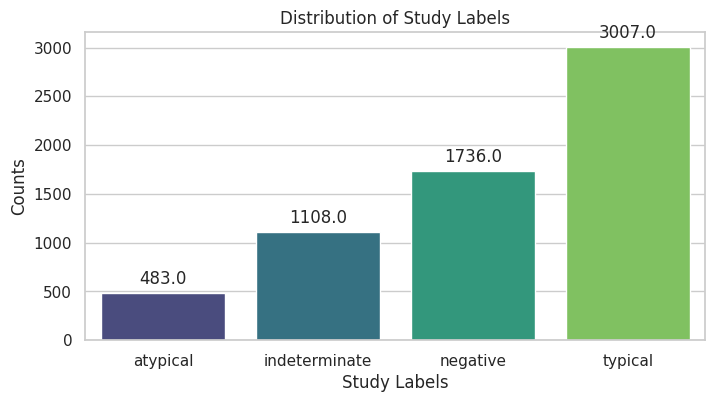

In [104]:
# Create a new DataFrame with counts aggregated by 'y_label'.
agg_df = train_labels.groupby('y_label').size().reset_index(name='count')

# Create a bar plot.
plt.figure(figsize=(8, 4))
ax = sns.barplot(x='y_label',
                 y='count',
                 data=agg_df,
                 palette='viridis')

# Add annotations with counts.
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title.
plt.xlabel('Study Labels')
plt.ylabel('Counts')
plt.title('Distribution of Study Labels')

# Show the plot
plt.show()

The majority of study cases exhibit a typical pneumonia appearance, followed by a substantial number of cases identified as negative for pneumonia and those with an indeterminate presentation. Cases characterized by an atypical pneumonia appearance are observed less frequently.
This showcase the need to balance the dataset if it has to be used for implementing automatic classification algorithms.

### 2.2 Image Labels distribution

It is useful to see how many images with no image labels (bounding boxes) do we have for each study label. 

In [110]:
# Check if there is any image that has both, a bbox identified
# with box_label == 'opacity 1', and no bbox, identified with box_label == 'none 1'.

both_labels = train_boxes.groupby('id')['box_label'].nunique()
# Get the list of images that have both labels.
both_labels = both_labels[both_labels == 2].index.tolist()

print(f'There are {len(both_labels)} images with both bbox and no bbox labels.')

There are 0 images with both bbox and no bbox labels.


In [58]:
no_bbx = train_boxes.loc[train_boxes.box_label == 'none 1']
print(f'There is a total of {len(no_bbx)} images without bbox'+
      f' for a total of {len(train_labels)} images.')

There is a total of 2040 images without bbox for a total of 6334 images.


In [113]:
df_no_duplicate_ids = train_boxes.drop_duplicates(subset='id',
                                                  keep='first')

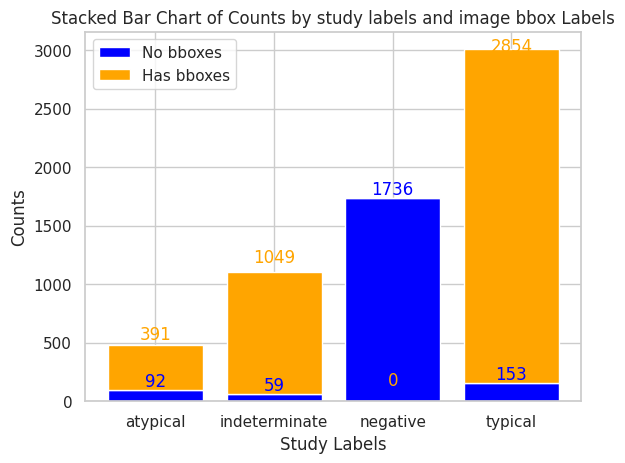

In [114]:
# Create a new DataFrame with counts aggregated by 'y_label', 'box_label'.
agg_df = (df_no_duplicate_ids.groupby(['y_label', 'box_label'])
                    .size()
                    .reset_index(name='count'))

# Pivot the DataFrame to have 'box_label' as columns.
pivot_df = agg_df.pivot_table(index='y_label',
                              columns='box_label',
                              values='count',
                              fill_value=0).reset_index()

# Create a stacked bar chart.
fig, ax = plt.subplots()

# Set the positions for each bar.
positions = range(len(pivot_df))

no_bbox_bar = ax.bar(positions,
                     pivot_df['none 1'],
                     label='No bboxes',
                     color='blue')

bbox_bar = ax.bar(positions,
                  pivot_df['opacity 1'],
                  label='Has bboxes',
                  color='orange',
                  bottom=pivot_df['none 1'])

# Add annotations with counts.
for bar, count in zip(no_bbox_bar, pivot_df['none 1']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            str(count),
            ha='center',
            va='bottom',
            color=(0, 0, 1),
            fontsize=12)

for bar, count in zip(bbox_bar, pivot_df['opacity 1']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 100,
            str(count),
            ha='center',
            va='bottom',
            color=(1, 0.647, 0),
            fontsize=12)

# Set labels and title.
ax.set_xticks(positions)
ax.set_xticklabels(pivot_df['y_label'])
ax.set_ylabel('Counts')
ax.set_xlabel('Study Labels')
ax.set_title('Stacked Bar Chart of Counts by study labels and image bbox Labels')
ax.legend()

plt.show()

As it can be seen, the category 'Negative for Pneumonia' has no bounding boxes on image labels. If the goal is to detect bounding boxes for the rest of categories, cleaning up those images that have no bbox is suggested.

### 2.3 Images' metadata distributions":

DICOM files contain metadata that is worth exploring.

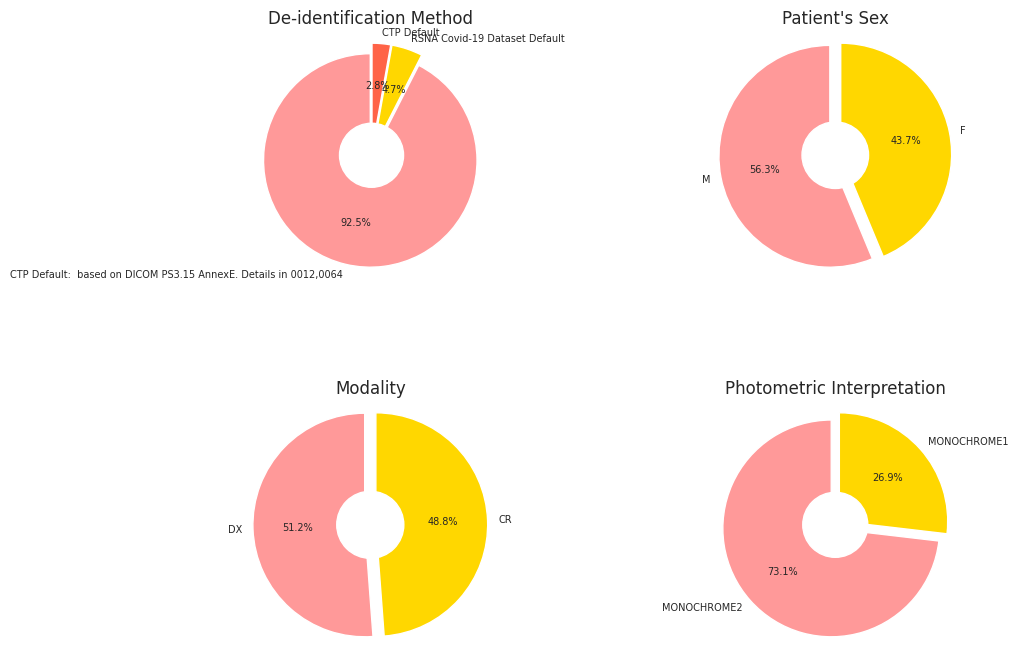

In [30]:
def label_sizes(col):
    """
    Function to extract labels, sizes and unique values for a specific column.
    """
    labels = df_metadata[col].value_counts().index
    sizes = df_metadata[col].value_counts()
    uc = df_metadata[col].nunique() #To be used in explode param.

    return labels, sizes, uc


columns = ["De-identification Method", "Patient's Sex",
           "Modality","Photometric Interpretation"]

data_list = [label_sizes(col) for col in columns]

# Create pie charts
colors = ['#FF9999', '#FFD700', '#FF6347', '#FFB6C1', '#E9967A', '#F08080']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

axes = axes.flatten()

for i, ax in enumerate(axes):
    labels, sizes, uc = data_list[i]
    explode = (0.05,) * uc
    colors = colors[:len(labels)]

    ax.pie(sizes,
           labels=labels,
           autopct='%1.1f%%',
           colors=colors,
           explode=explode,
           startangle=90,
           textprops={'fontsize': 7})
    # Drawing a circle at the center to make it look like a donut chart.
    ax.add_artist(plt.Circle((0, 0), 0.30, fc='white'))
    ax.set_title(columns[i], fontsize=12)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [31]:
def horizontal_plot(df, ylabel, title):

    colors = ['#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#ff6666']

    plt.figure(figsize=(8, 6))
    sns.countplot(y=ylabel,
                  data=df,
                  palette=colors)

    plt.xlabel('count', fontsize=12, color='gray')
    plt.ylabel(ylabel, fontsize=12, color='gray')
    plt.title(title, fontsize=16, color='#333333', weight='bold')

    # Add grid for better readability
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

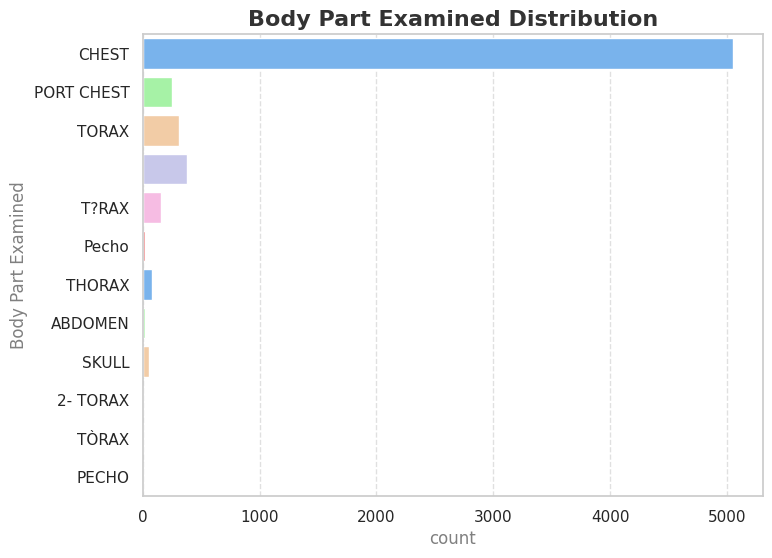

In [32]:
horizontal_plot(df_metadata,
                "Body Part Examined",
                'Body Part Examined Distribution')

In [33]:
horizontal_plot(df_metadata,
                "Private Creator",
                'Private Creator Distribution')

### 3. Image examples for each case:

###  3.1 Images for each study case:

In [34]:
def format_boxes(image_list):
    """
    Function recieves a list strings, that consist on the image 'id's for different images,
    and reformat them in the following way:
        - If box_label for the image starts with None, leave box empty (empty list).
        - Whenever it encounters 'opacity' in box_label, append the box info to create one list of 
          boxes per each image. 
    Example : If we have the following boxes per image ['opacity 1 72 58 18 24 opacity 1 2 59 33 23',
                               'none 1 0 0 1 1']
              OUT result = [[72, 58, 18, 24, 2, 59, 33, 23], []]
    Args: 
        image_list: list of image 'id's to extract boxes from. (list of strings)
    Outputs:
        result: List of Lists of reformated boxes. (list of lists)
    """
    result = []
    for i, im_id in enumerate(image_list):  # find id in train_boxes
        boxes_info = train_boxes.loc[train_boxes.id == im_id]
        boxes = []
        for _, box in boxes_info.iterrows():
            if box['box_label'].startswith('opacity'):
                boxes.extend([box['xmin'], box['ymin'], box['xmax'], box['ymax']])
            else: 
                boxes.extend([])
        result.append(boxes)
    return result

#### 3.1.1 Negative for Pneumonia

In [35]:
trues = train_labels.loc[train_labels["Negative for Pneumonia"] == 1][:4]
imgs_test_path = trues.image_path.tolist()
img_test_boxes = format_boxes(trues.id.tolist())

plot_DICOM(imgs_test_path, img_test_boxes,
           "Negative for Pneumonia Examples")

There is no ROI present in image 1.
There is no ROI present in image 2.
There is no ROI present in image 3.
There is no ROI present in image 4.


#### 3.1.2 Typical Appearance

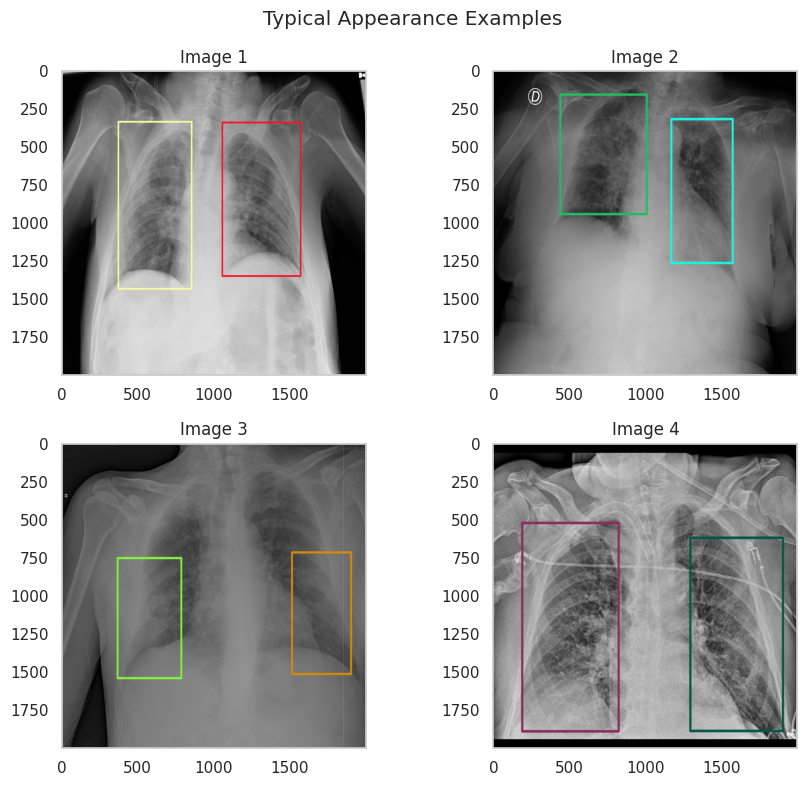

In [36]:
trues = train_labels.loc[train_labels["Typical Appearance"] == 1][:4]
imgs_test_path = trues.image_path.tolist()
img_test_boxes = format_boxes(trues.id.tolist())

plot_DICOM(imgs_test_path, img_test_boxes,
           "Typical Appearance Examples")

#### 3.1.3 Atypical Appearance

There is no ROI present in image 4.


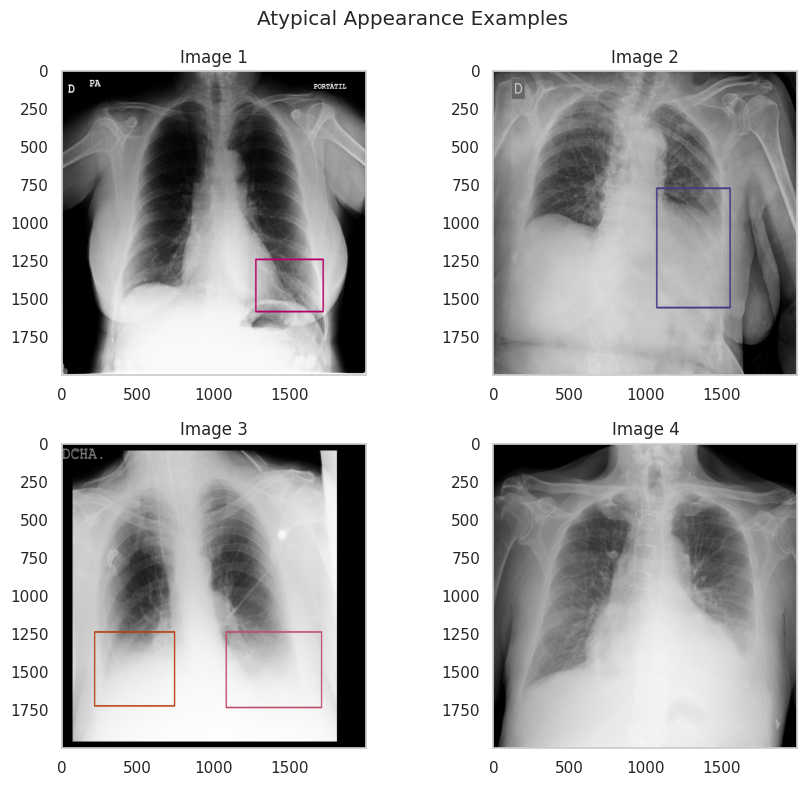

In [37]:
trues = train_labels.loc[train_labels["Atypical Appearance"] == 1][:4]
imgs_test_path = trues.image_path.tolist()
img_test_boxes = format_boxes(trues.id.tolist())

plot_DICOM(imgs_test_path, img_test_boxes,
           "Atypical Appearance Examples")

#### 3.1.4 Indeterminate Appearance

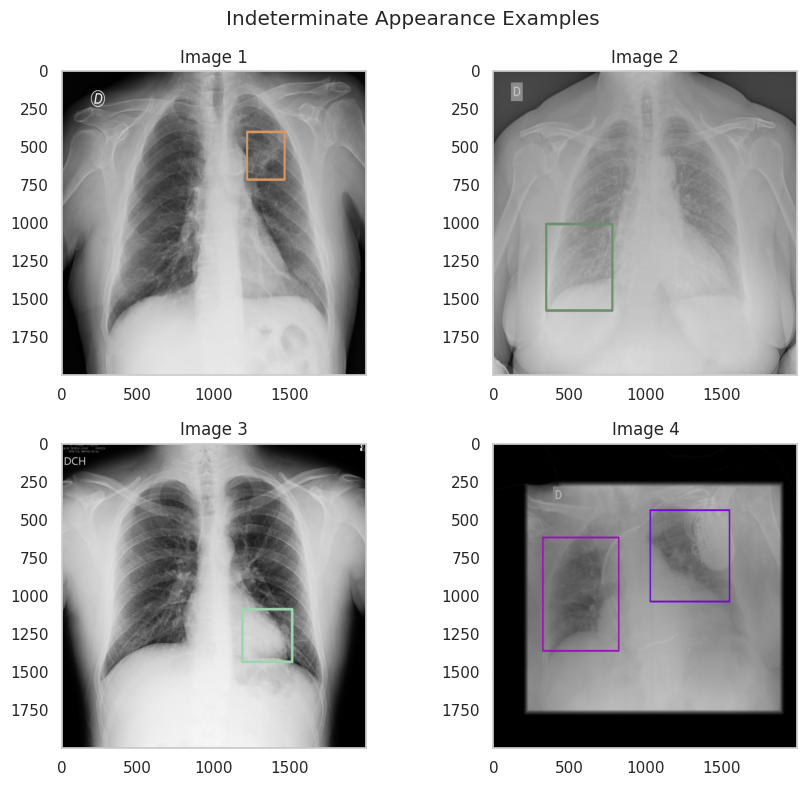

In [38]:
trues = train_labels.loc[train_labels["Indeterminate Appearance"] == 1][:4]
imgs_test_path = trues.image_path.tolist()
img_test_boxes = format_boxes(trues.id.tolist())

plot_DICOM(imgs_test_path, img_test_boxes,
           "Indeterminate Appearance Examples")

#### 3.1.5 Comparison between classes:

There is no ROI present in image 4.


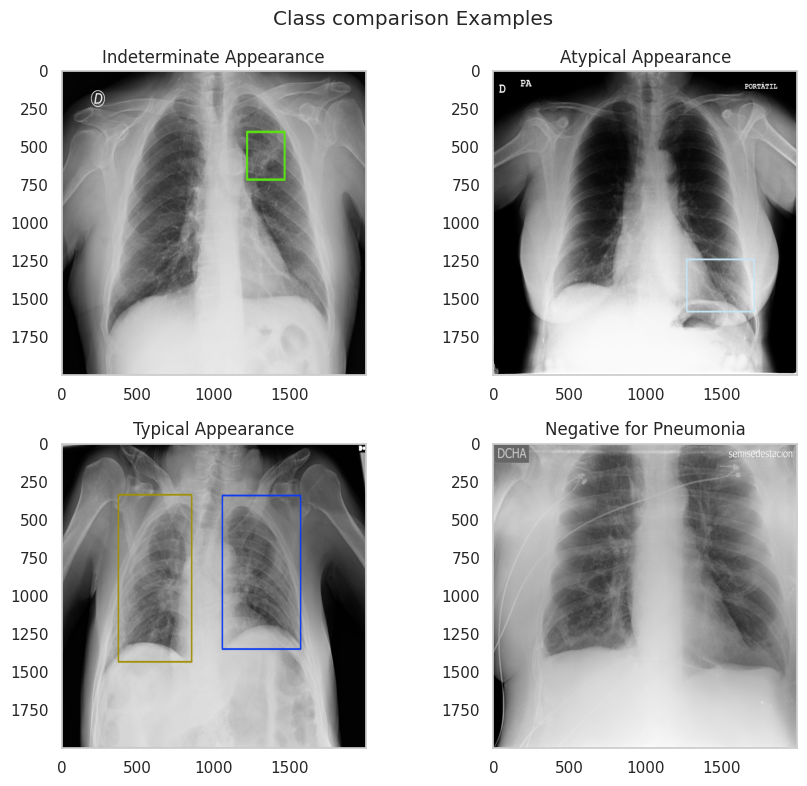

In [39]:
indeterminate = train_labels.loc[train_labels["Indeterminate Appearance"] == 1][:1]
atypical = train_labels.loc[train_labels["Atypical Appearance"] == 1][:1]
typical = train_labels.loc[train_labels["Typical Appearance"] == 1][:1]
negative = train_labels.loc[train_labels["Negative for Pneumonia"] == 1][:1]

imgs_test_path = indeterminate.image_path.tolist() + \
                 atypical.image_path.tolist() + \
                 typical.image_path.tolist() + \
                 negative.image_path.tolist()
img_test_boxes = indeterminate.id.tolist() + \
                 atypical.id.tolist() + \
                 typical.id.tolist() + \
                 negative.id.tolist()
img_test_boxes = format_boxes(img_test_boxes)

plot_DICOM(imgs_test_path, img_test_boxes,
           "Class comparison Examples", ["Indeterminate Appearance", "Atypical Appearance",
                                         "Typical Appearance", "Negative for Pneumonia"])

There is no ROI present in image 4.


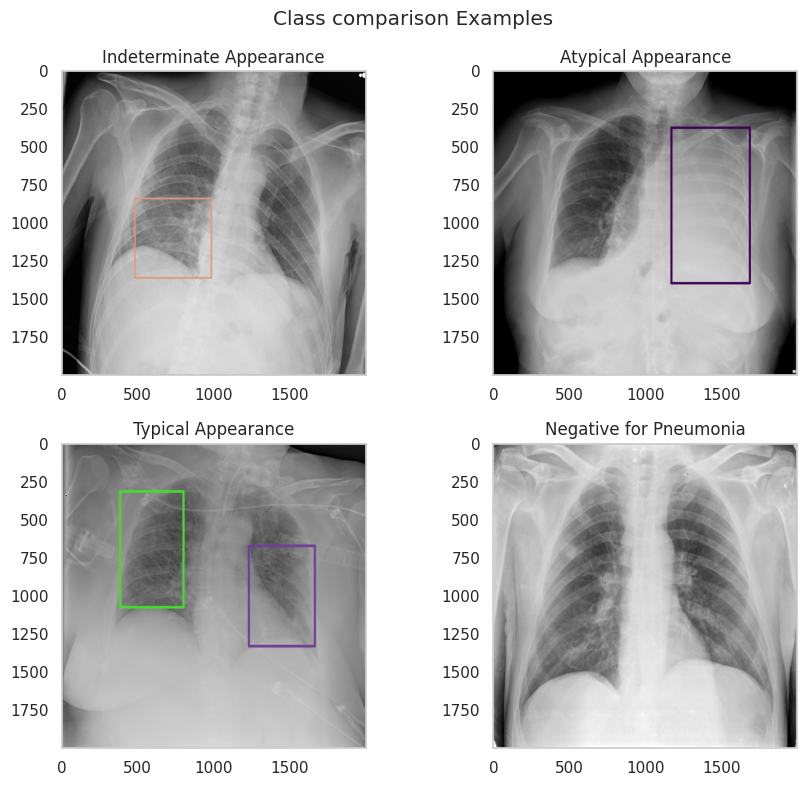

In [40]:
indeterminate = train_labels.loc[train_labels["Indeterminate Appearance"] == 1][4:5]
atypical = train_labels.loc[train_labels["Atypical Appearance"] == 1][4:5]
typical = train_labels.loc[train_labels["Typical Appearance"] == 1][4:5]
negative = train_labels.loc[train_labels["Negative for Pneumonia"] == 1][4:5]

imgs_test_path = indeterminate.image_path.tolist() + \
                 atypical.image_path.tolist() + \
                 typical.image_path.tolist() + \
                 negative.image_path.tolist()
img_test_boxes = indeterminate.id.tolist() + \
                 atypical.id.tolist() + \
                 typical.id.tolist() + \
                 negative.id.tolist()
img_test_boxes = format_boxes(img_test_boxes)

plot_DICOM(imgs_test_path, img_test_boxes,
           "Class comparison Examples", ["Indeterminate Appearance", "Atypical Appearance",
                                         "Typical Appearance", "Negative for Pneumonia"])

There is no ROI present in image 4.


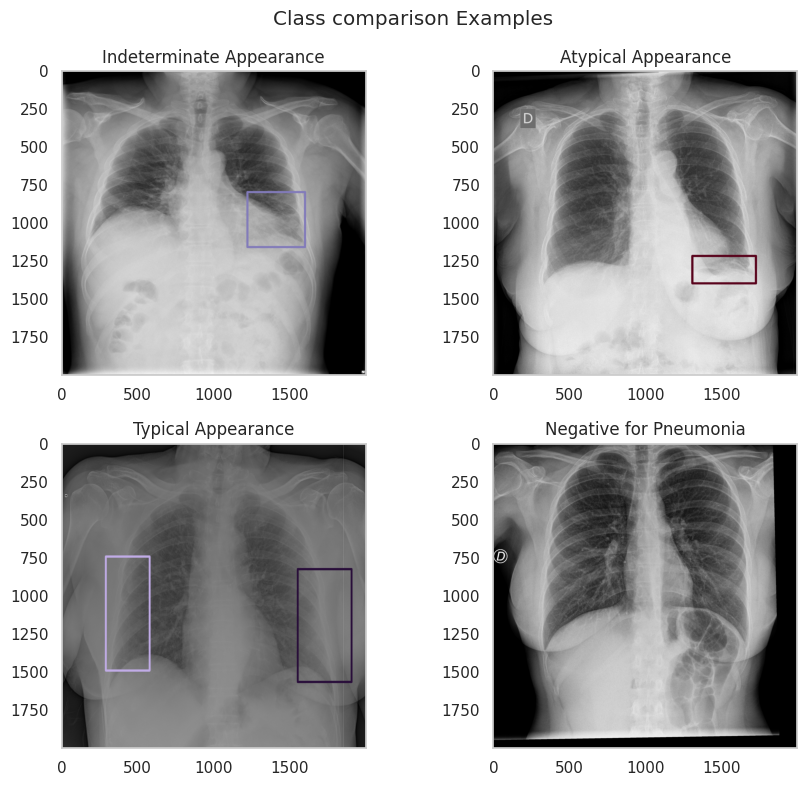

In [41]:
indeterminate = train_labels.loc[train_labels["Indeterminate Appearance"] == 1][8:9]
atypical = train_labels.loc[train_labels["Atypical Appearance"] == 1][8:9]
typical = train_labels.loc[train_labels["Typical Appearance"] == 1][8:9]
negative = train_labels.loc[train_labels["Negative for Pneumonia"] == 1][8:9]

imgs_test_path = indeterminate.image_path.tolist() + \
                 atypical.image_path.tolist() + \
                 typical.image_path.tolist() + \
                 negative.image_path.tolist()
img_test_boxes = indeterminate.id.tolist() + \
                 atypical.id.tolist() + \
                 typical.id.tolist() + \
                 negative.id.tolist()
img_test_boxes = format_boxes(img_test_boxes)

plot_DICOM(imgs_test_path, img_test_boxes,
           "Class comparison Examples", ["Indeterminate Appearance", "Atypical Appearance",
                                         "Typical Appearance", "Negative for Pneumonia"])

###  3.2 Images for different metadata attributes:

In [42]:
def extract_image_path_and_boxes(id_list):
    """
    Function obtains a list of image paths and boxes (without format) from given image id list.
    """
    imgs_test_path = []
    img_test_boxes = []
    for imgid in id_list:
        loc = train_labels.loc[train_labels["id"] == imgid]
        imgs_test_path.append(loc.image_path.tolist()[0])
        img_test_boxes.append(loc.id.tolist()[0])

    return imgs_test_path, img_test_boxes
    

#### 3.2.1 Modality Distribution

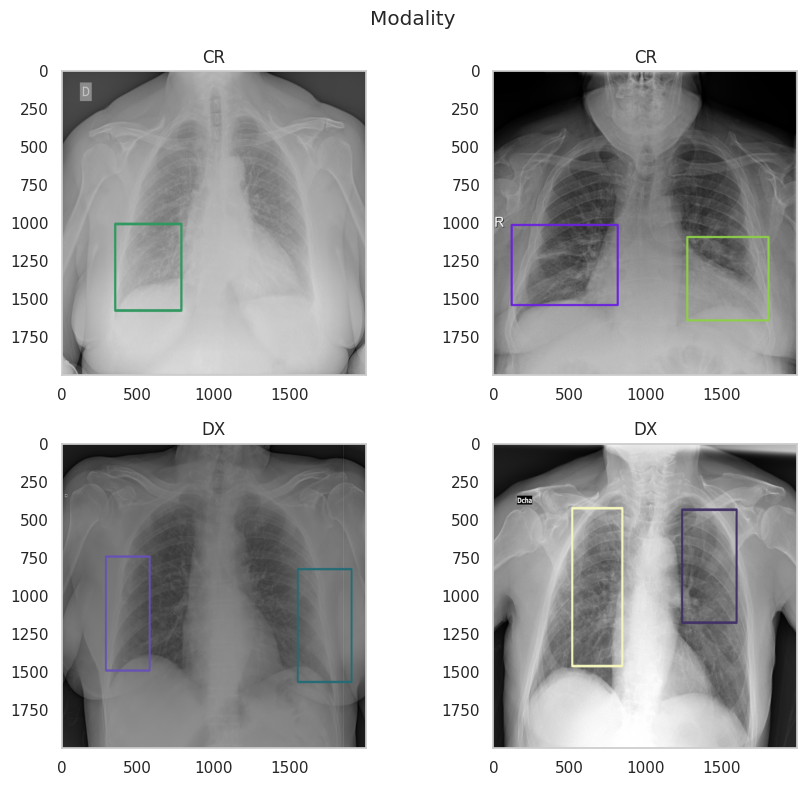

In [43]:
cr = df_metadata.loc[df_metadata["Modality"] == "CR"]["id"][7:9].tolist()
dx = df_metadata.loc[df_metadata["Modality"] == "DX"]["id"][7:9].tolist()

cr_path, cr_boxes = extract_image_path_and_boxes(cr)
dx_path, dx_boxes = extract_image_path_and_boxes(dx)

imgs_test_path = cr_path + dx_path     
img_test_boxes = cr_boxes + dx_boxes
img_test_boxes = format_boxes(img_test_boxes)

plot_DICOM(imgs_test_path, img_test_boxes,
           "Modality", ["CR", "CR", "DX", "DX"])

There is no ROI present in image 1.


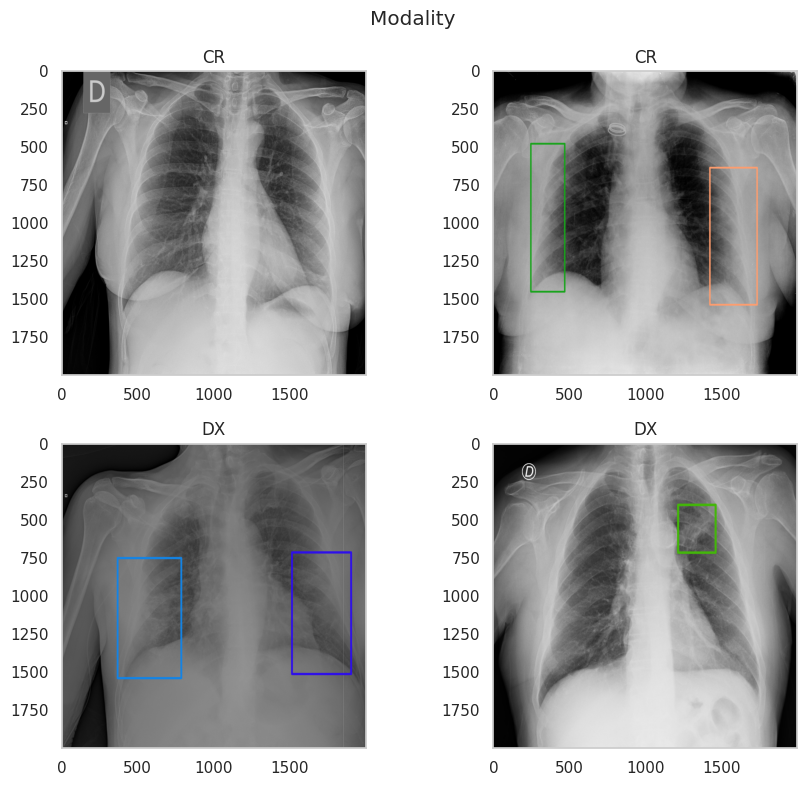

In [44]:
cr = df_metadata.loc[df_metadata["Modality"] == "CR"]["id"][2:4].tolist()
dx = df_metadata.loc[df_metadata["Modality"] == "DX"]["id"][2:4].tolist()

cr_path, cr_boxes = extract_image_path_and_boxes(cr)
dx_path, dx_boxes = extract_image_path_and_boxes(dx)

imgs_test_path = cr_path + dx_path     
img_test_boxes = cr_boxes + dx_boxes
img_test_boxes = format_boxes(img_test_boxes)

plot_DICOM(imgs_test_path, img_test_boxes,
           "Modality", ["CR", "CR", "DX", "DX"])

#### 3.2.2 De-identification Method

There is no ROI present in image 1.
There is no ROI present in image 5.


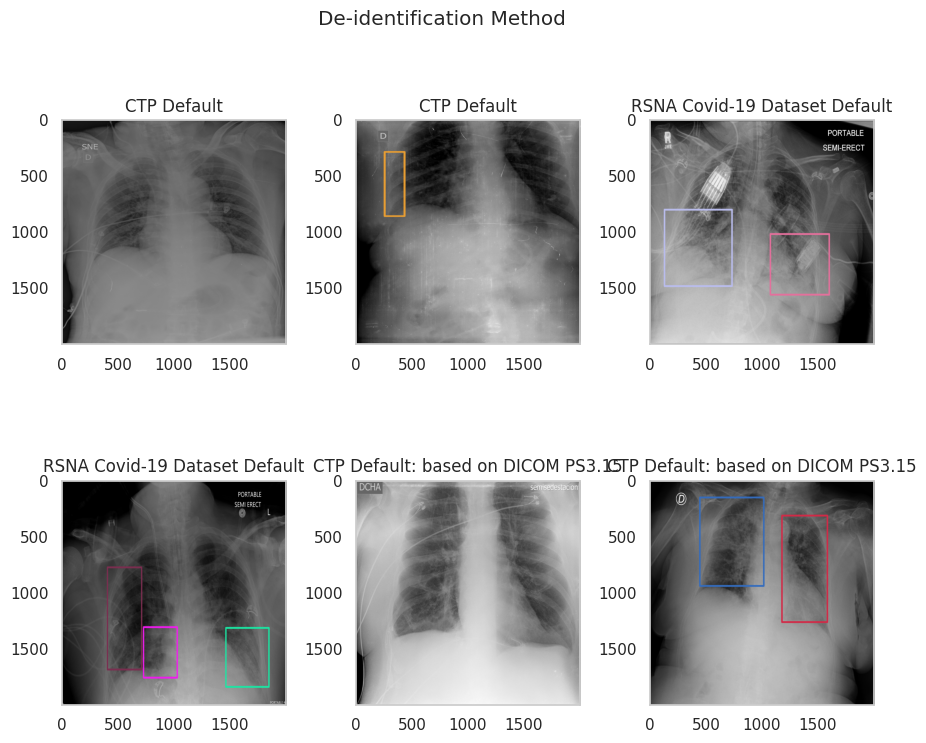

In [115]:
default = df_metadata.loc[df_metadata["De-identification Method"] == "CTP Default"]["id"][1:3].tolist()
rsna = df_metadata.loc[df_metadata["De-identification Method"] == "RSNA Covid-19 Dataset Default"]["id"][1:3].tolist()
mask = df_metadata["De-identification Method"].str.startswith("CTP Default:")
dicom = df_metadata[mask]["id"][1:3].tolist()

default_path, default_boxes = extract_image_path_and_boxes(default)
rsna_path, rsna_boxes = extract_image_path_and_boxes(rsna)
dicom_path, dicom_boxes = extract_image_path_and_boxes(dicom)

imgs_test_path = default_path + rsna_path + dicom_path
img_test_boxes = default_boxes + rsna_boxes + dicom_boxes
img_test_boxes = format_boxes(img_test_boxes)

plot_DICOM(imgs_test_path, img_test_boxes,
           "De-identification Method", ["CTP Default", "CTP Default",
                                        "RSNA Covid-19 Dataset Default", "RSNA Covid-19 Dataset Default",
                                        "CTP Default: based on DICOM PS3.15", "CTP Default: based on DICOM PS3.15"])

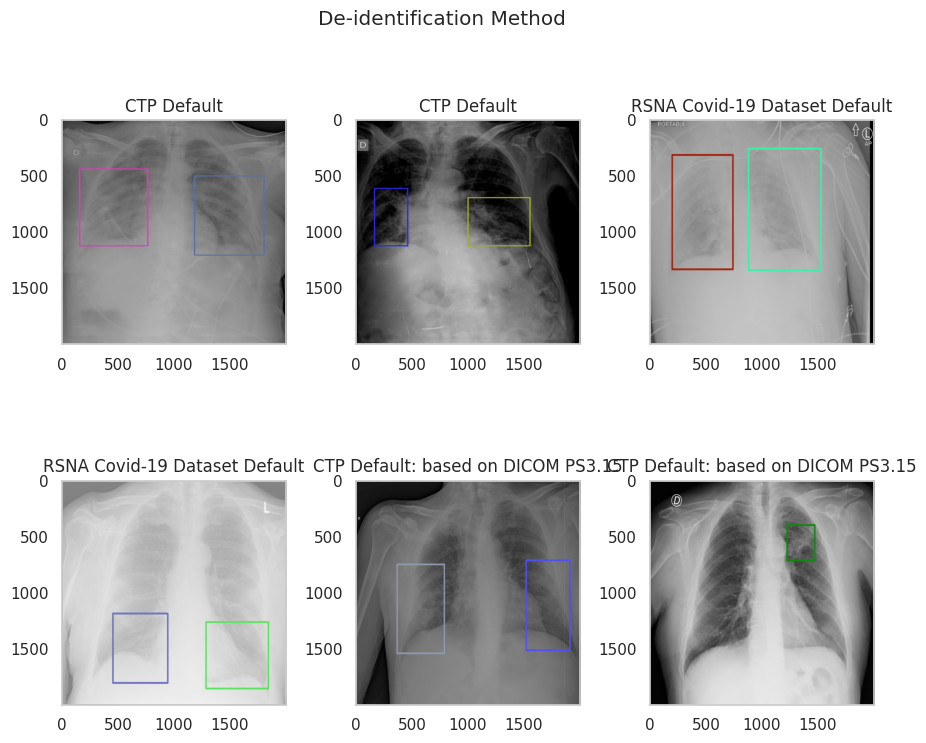

In [116]:
default = df_metadata.loc[df_metadata["De-identification Method"] == "CTP Default"]["id"][4:6].tolist()
rsna = df_metadata.loc[df_metadata["De-identification Method"] == "RSNA Covid-19 Dataset Default"]["id"][4:6].tolist()
mask = df_metadata["De-identification Method"].str.startswith("CTP Default:")
dicom = df_metadata[mask]["id"][4:6].tolist()

default_path, default_boxes = extract_image_path_and_boxes(default)
rsna_path, rsna_boxes = extract_image_path_and_boxes(rsna)
dicom_path, dicom_boxes = extract_image_path_and_boxes(dicom)

imgs_test_path = default_path + rsna_path + dicom_path
img_test_boxes = default_boxes + rsna_boxes + dicom_boxes
img_test_boxes = format_boxes(img_test_boxes)

plot_DICOM(imgs_test_path, img_test_boxes,
           "De-identification Method", ["CTP Default", "CTP Default",
                                        "RSNA Covid-19 Dataset Default", "RSNA Covid-19 Dataset Default",
                                        "CTP Default: based on DICOM PS3.15", "CTP Default: based on DICOM PS3.15"])

#### 3.2.3 Photometric Interpretation

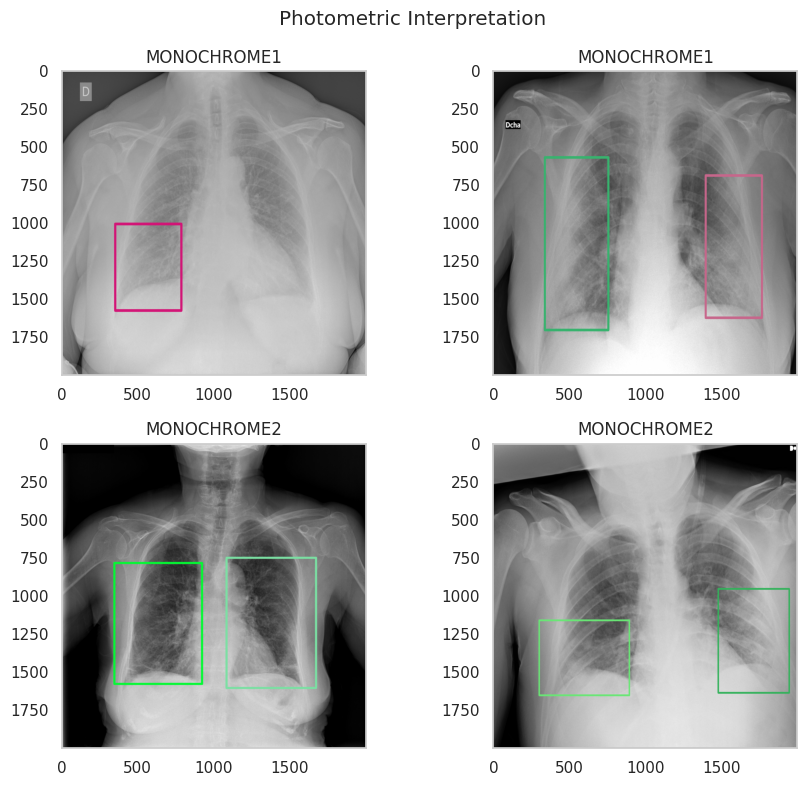

In [46]:
m1 = df_metadata.loc[df_metadata["Photometric Interpretation"] == "MONOCHROME1"]["id"][7:9].tolist()
m2 = df_metadata.loc[df_metadata["Photometric Interpretation"] == "MONOCHROME2"]["id"][7:9].tolist()

m1_path, m1_boxes = extract_image_path_and_boxes(m1)
m2_path, m2_boxes = extract_image_path_and_boxes(m2)

imgs_test_path = m1_path + m2_path     
img_test_boxes = m1_boxes + m2_boxes
img_test_boxes = format_boxes(img_test_boxes)

plot_DICOM(imgs_test_path, img_test_boxes,
           "Photometric Interpretation", ["MONOCHROME1", "MONOCHROME1", "MONOCHROME2", "MONOCHROME2"])

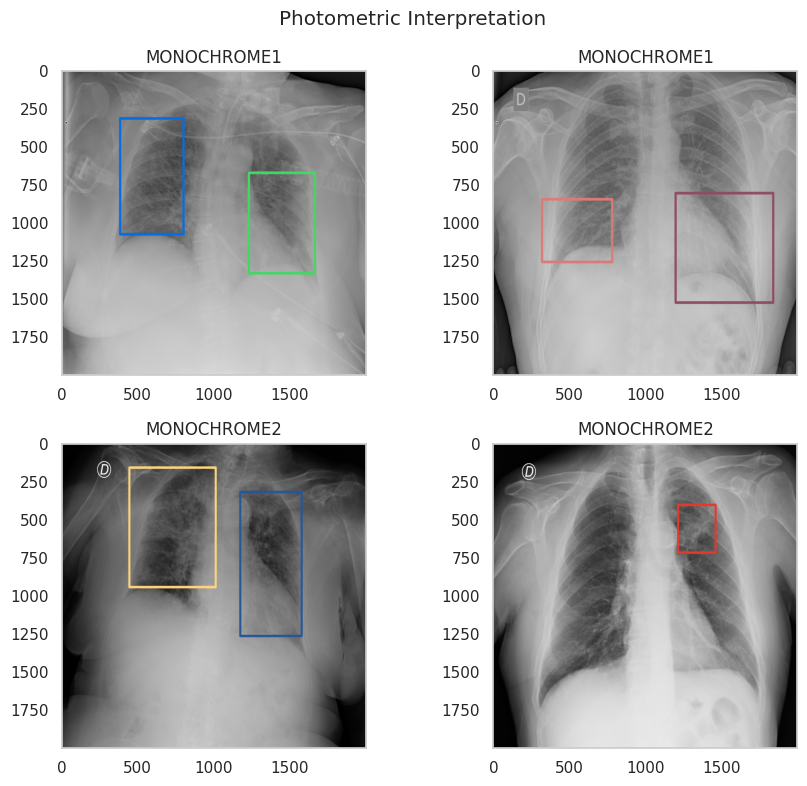

In [47]:
m1 = df_metadata.loc[df_metadata["Photometric Interpretation"] == "MONOCHROME1"]["id"][2:4].tolist()
m2 = df_metadata.loc[df_metadata["Photometric Interpretation"] == "MONOCHROME2"]["id"][2:4].tolist()

m1_path, m1_boxes = extract_image_path_and_boxes(m1)
m2_path, m2_boxes = extract_image_path_and_boxes(m2)

imgs_test_path = m1_path + m2_path     
img_test_boxes = m1_boxes + m2_boxes
img_test_boxes = format_boxes(img_test_boxes)

plot_DICOM(imgs_test_path, img_test_boxes,
           "Photometric Interpretation", ["MONOCHROME1", "MONOCHROME1", "MONOCHROME2", "MONOCHROME2"])

#### 3.2.4 Patient's Sex

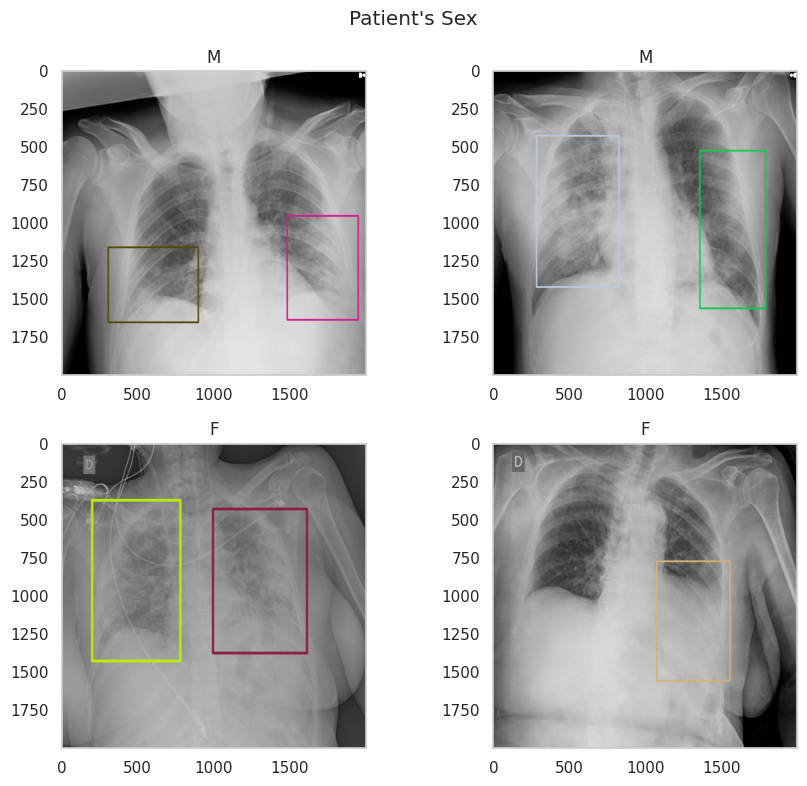

In [48]:
m = df_metadata.loc[df_metadata["Patient's Sex"] == "M"]["id"][7:9].tolist()
f = df_metadata.loc[df_metadata["Patient's Sex"] == "F"]["id"][7:9].tolist()

m_path, m_boxes = extract_image_path_and_boxes(m)
f_path, f_boxes = extract_image_path_and_boxes(f)

imgs_test_path = m_path + f_path     
img_test_boxes = m_boxes + f_boxes
img_test_boxes = format_boxes(img_test_boxes)

plot_DICOM(imgs_test_path, img_test_boxes,
           "Patient's Sex", ["M", "M", "F", "F"])

There is no ROI present in image 1.
There is no ROI present in image 2.
There is no ROI present in image 4.


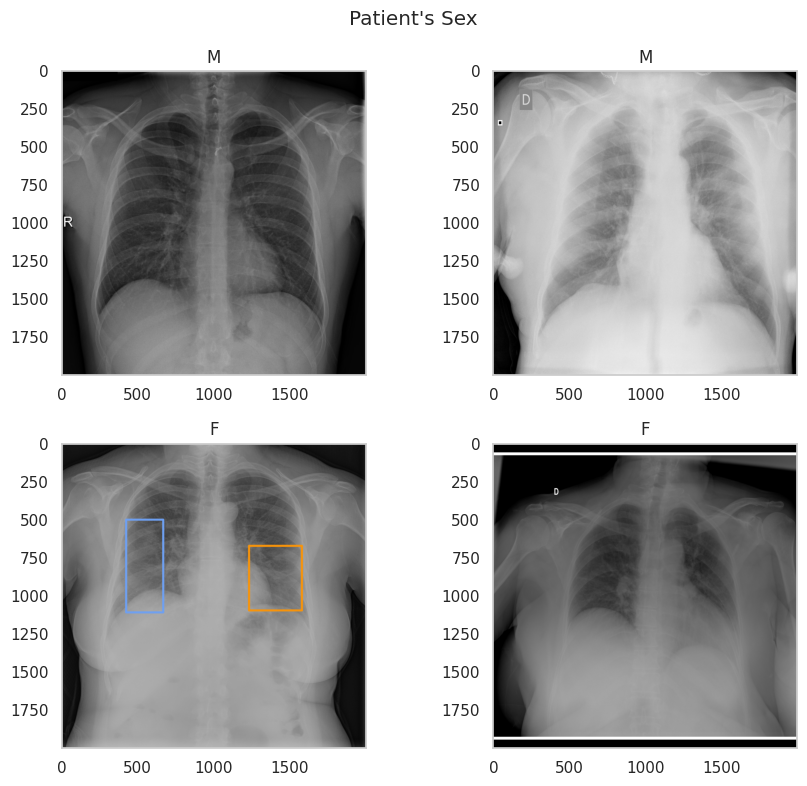

In [49]:
m = df_metadata.loc[df_metadata["Patient's Sex"] == "M"]["id"][30:32].tolist()
f = df_metadata.loc[df_metadata["Patient's Sex"] == "F"]["id"][30:32].tolist()

m_path, m_boxes = extract_image_path_and_boxes(m)
f_path, f_boxes = extract_image_path_and_boxes(f)

imgs_test_path = m_path + f_path     
img_test_boxes = m_boxes + f_boxes
img_test_boxes = format_boxes(img_test_boxes)

plot_DICOM(imgs_test_path, img_test_boxes,
           "Patient's Sex", ["M", "M", "F", "F"])

#### 3.2.5 Body Part Examined

There is no ROI present in image 4.
There is no ROI present in image 6.
There is no ROI present in image 8.


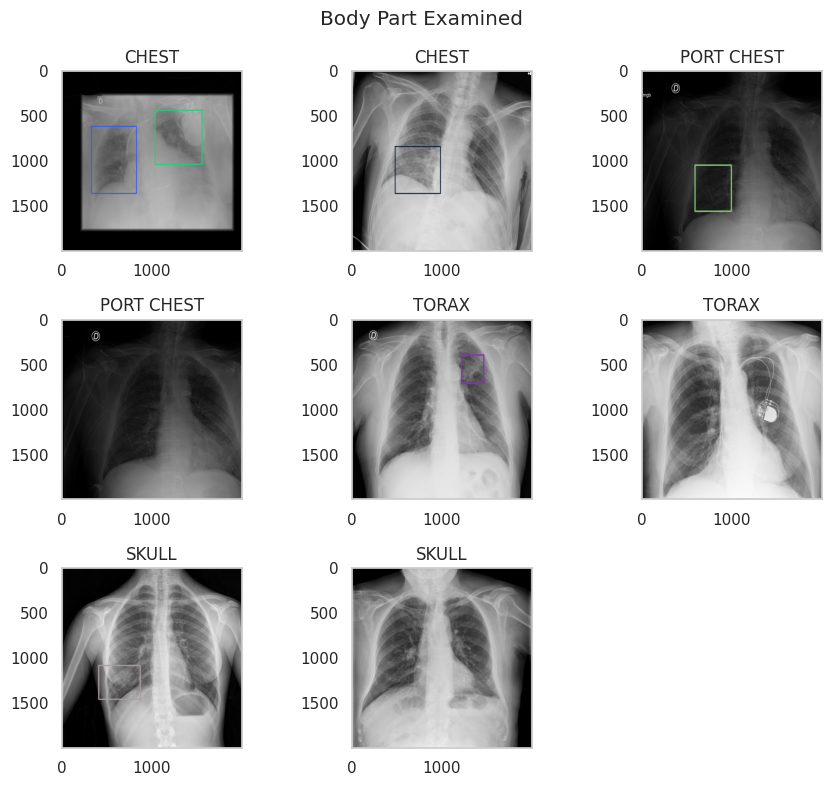

In [50]:
chest = df_metadata.loc[df_metadata["Body Part Examined"] == "CHEST"]["id"][30:32].tolist()
port = df_metadata.loc[df_metadata["Body Part Examined"] == "PORT CHEST"]["id"][30:32].tolist()
torax = df_metadata.loc[df_metadata["Body Part Examined"] == "TORAX"]["id"][0:2].tolist()
skull = df_metadata.loc[df_metadata["Body Part Examined"] == "SKULL"]["id"][0:2].tolist()

chest_path, chest_boxes = extract_image_path_and_boxes(chest)
port_path, port_boxes = extract_image_path_and_boxes(port)
torax_path, torax_boxes = extract_image_path_and_boxes(torax)
skull_path, skull_boxes = extract_image_path_and_boxes(skull)

imgs_test_path = chest_path + port_path + torax_path + skull_path   
img_test_boxes = chest_boxes + port_boxes + torax_boxes + skull_boxes
img_test_boxes = format_boxes(img_test_boxes)

plot_DICOM(imgs_test_path, img_test_boxes,
           "Body Part Examined", ["CHEST", "CHEST",
                               "PORT CHEST", "PORT CHEST",
                               "TORAX", "TORAX",
                               "SKULL", "SKULL"])

There is no ROI present in image 2.
There is no ROI present in image 5.
There is no ROI present in image 6.
There is no ROI present in image 7.
There is no ROI present in image 8.


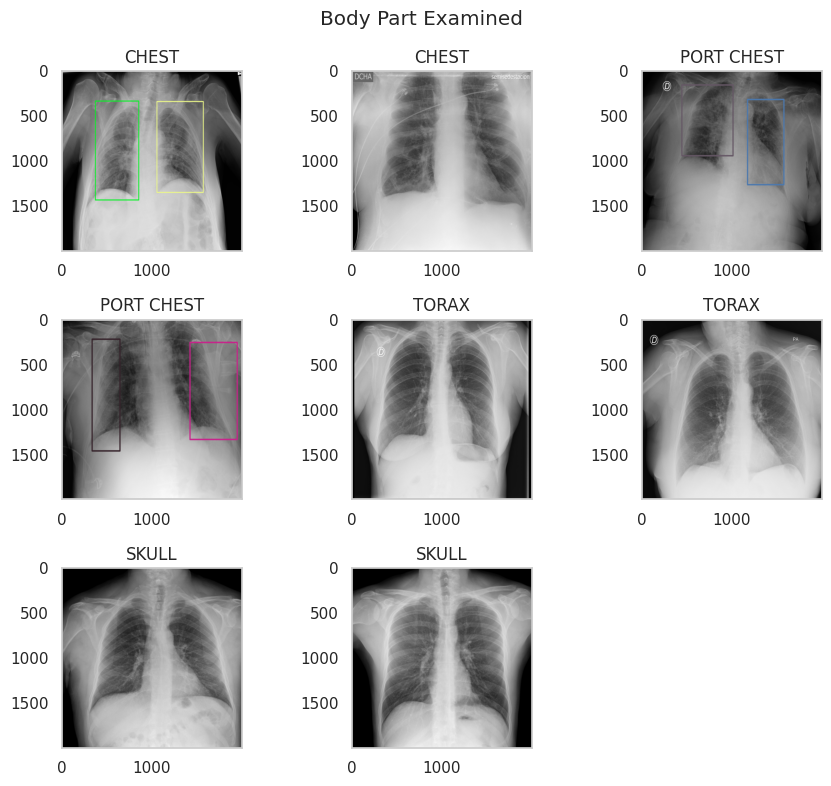

In [51]:
chest = df_metadata.loc[df_metadata["Body Part Examined"] == "CHEST"]["id"][0:2].tolist()
port = df_metadata.loc[df_metadata["Body Part Examined"] == "PORT CHEST"]["id"][0:2].tolist()
torax = df_metadata.loc[df_metadata["Body Part Examined"] == "TORAX"]["id"][2:4].tolist()
skull = df_metadata.loc[df_metadata["Body Part Examined"] == "SKULL"]["id"][2:4].tolist()

chest_path, chest_boxes = extract_image_path_and_boxes(chest)
port_path, port_boxes = extract_image_path_and_boxes(port)
torax_path, torax_boxes = extract_image_path_and_boxes(torax)
skull_path, skull_boxes = extract_image_path_and_boxes(skull)

imgs_test_path = chest_path + port_path + torax_path + skull_path   
img_test_boxes = chest_boxes + port_boxes + torax_boxes + skull_boxes
img_test_boxes = format_boxes(img_test_boxes)

plot_DICOM(imgs_test_path, img_test_boxes,
           "Body Part Examined", ["CHEST", "CHEST",
                               "PORT CHEST", "PORT CHEST",
                               "TORAX", "TORAX",
                               "SKULL", "SKULL"])

#### 3.2.6 Private Creator

There is no ROI present in image 3.
There is no ROI present in image 4.
There is no ROI present in image 5.


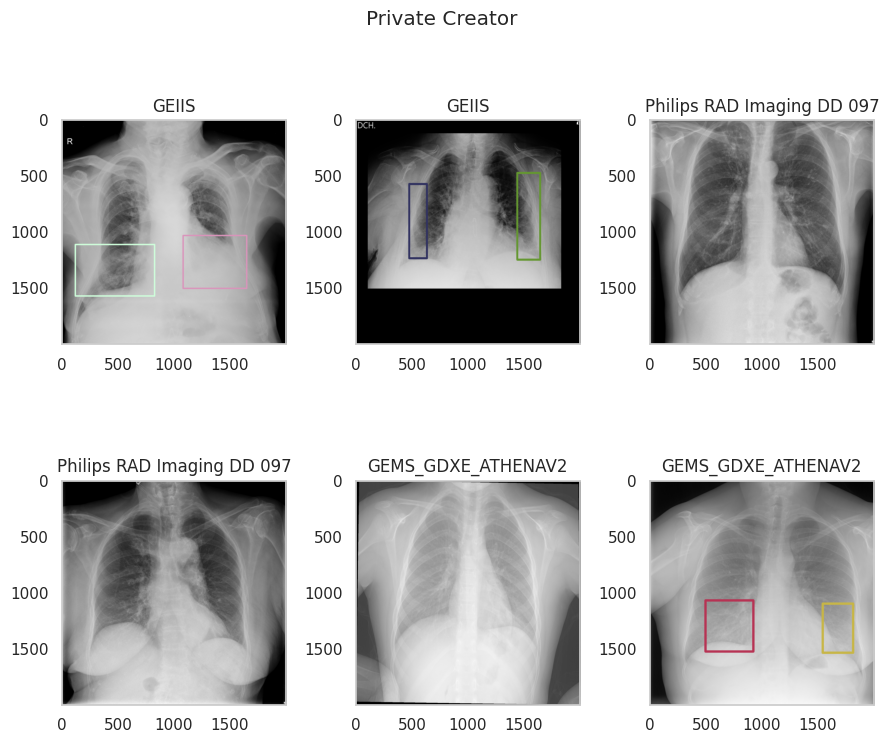

In [52]:
gehiis = df_metadata.loc[df_metadata["Private Creator"] == "GEIIS"]["id"][30:32].tolist()
philips = df_metadata.loc[df_metadata["Private Creator"] == "Philips RAD Imaging DD 097"]["id"][30:32].tolist()
gems = df_metadata.loc[df_metadata["Private Creator"] == "GEMS_GDXE_ATHENAV2_INTERNAL_USE"]["id"][0:2].tolist()

gehiis_path, gehiis_boxes = extract_image_path_and_boxes(gehiis)
philips_path, philips_boxes = extract_image_path_and_boxes(philips)
gems_path, gems_boxes = extract_image_path_and_boxes(gems)

imgs_test_path = gehiis_path + philips_path + gems_path    
img_test_boxes = gehiis_boxes + philips_boxes + gems_boxes
img_test_boxes = format_boxes(img_test_boxes)

plot_DICOM(imgs_test_path, img_test_boxes,
           "Private Creator", ["GEIIS", "GEIIS",
                               "Philips RAD Imaging DD 097", "Philips RAD Imaging DD 097",
                               "GEMS_GDXE_ATHENAV2", "GEMS_GDXE_ATHENAV2"])

There is no ROI present in image 1.
There is no ROI present in image 6.


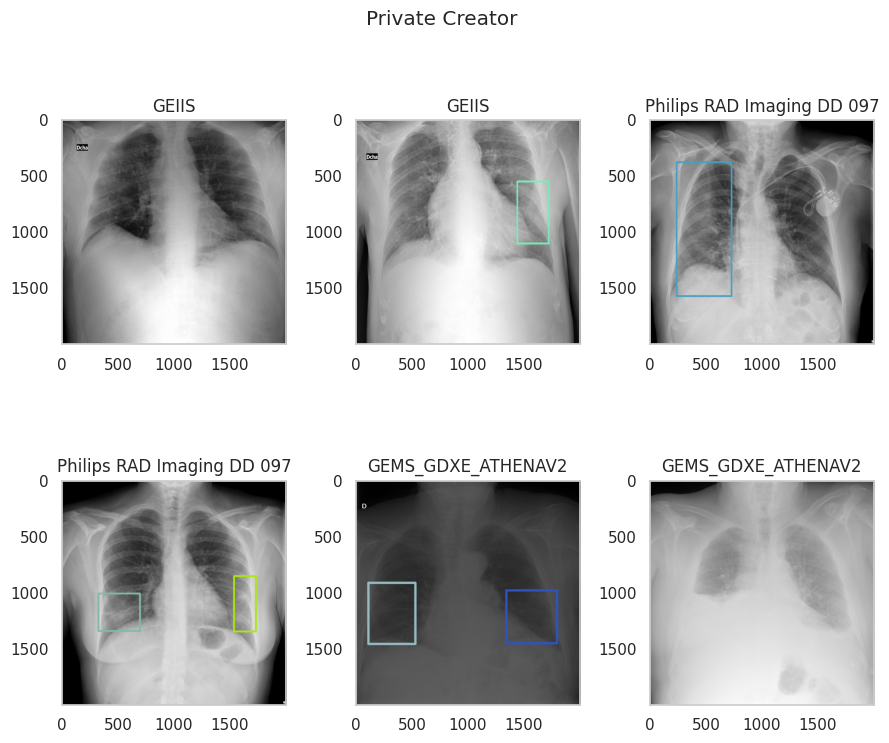

In [53]:
gehiis = df_metadata.loc[df_metadata["Private Creator"] == "GEIIS"]["id"][32:34].tolist()
philips = df_metadata.loc[df_metadata["Private Creator"] == "Philips RAD Imaging DD 097"]["id"][32:34].tolist()
gems = df_metadata.loc[df_metadata["Private Creator"] == "GEMS_GDXE_ATHENAV2_INTERNAL_USE"]["id"][2:4].tolist()

gehiis_path, gehiis_boxes = extract_image_path_and_boxes(gehiis)
philips_path, philips_boxes = extract_image_path_and_boxes(philips)
gems_path, gems_boxes = extract_image_path_and_boxes(gems)

imgs_test_path = gehiis_path + philips_path + gems_path    
img_test_boxes = gehiis_boxes + philips_boxes + gems_boxes
img_test_boxes = format_boxes(img_test_boxes)

plot_DICOM(imgs_test_path, img_test_boxes,
           "Private Creator", ["GEIIS", "GEIIS",
                               "Philips RAD Imaging DD 097", "Philips RAD Imaging DD 097",
                               "GEMS_GDXE_ATHENAV2", "GEMS_GDXE_ATHENAV2"])

## Disclaimers:

The code and procedures are original unless otherwise specified. That being said, the work is inspired by the EDA : https://www.kaggle.com/code/ruchi798/siim-covid-19-detection-eda-data-augmentation 
